**In the following notebook I am going to use CNN with data augmentation to classify number images from the MNIST dataset.**

**First let's import the libraries we are going to work with.**

In [1]:
#for data processing
import numpy as np 
import pandas as pd
from math import ceil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for model creation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#for evaluation and improvment
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

#for plotting the data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2021-10-19 18:39:47.536002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


**Now let's load the data!**

In [2]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
label = train_data["label"]
y = to_categorical(label, 10)
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
fulldata = pd.concat([train_data,test_data])
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#check if there is any missing values
fulldata.drop("label",axis = 1).isna().sum().sum()

0

**No missing values! :)**

**Let's see how our data looks**

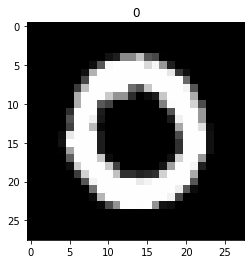

In [4]:
def show_img(dataset,row,label):
    if "label" in dataset.columns:
        x = np.array(dataset.drop("label",axis = 1).iloc[row]).reshape(28,28,1)
    else:
        x = np.array(dataset.iloc[row]).reshape(28,28,1)
    plt.imshow(x, cmap='gray')
    plt.title(label)
    plt.show()
show_img(train_data,1,label[1])
plt.show()



**let's see how are target is distributed**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

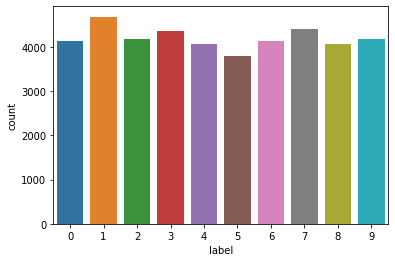

In [5]:
sns.countplot(label)
label.value_counts()/len(label)

**Our target is distributed uniformly**

**Let's make a simple model which we will try to improve later**

In [6]:
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding='same',input_shape=(28, 28, 1)),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding='same'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu",padding='same'),
    
    layers.Flatten(),
    layers.Dense(units=1024, activation="relu"),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=10, activation="softmax"),
])

2021-10-19 18:40:00.709724: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 18:40:00.715437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 18:40:00.847400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 18:40:00.848636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-19 18:40:00.848828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 18:40:00.879109: I tensorflow/stream_executor/platform/def

In [7]:
#split to train and test
X_train,X_test,y_train,y_test = train_test_split(train_data.drop("label",axis = 1),y,train_size = 0.9,random_state = 100)
#transofrm to relevent dimensions
X_train = X_train.to_numpy().reshape(X_train.shape[0],28,28,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],28,28,1)
#create model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#fit model
history = model.fit(
    X_train,y_train,
    validation_data = (X_test,y_test),
    batch_size = 128,
    epochs=50,
    verbose=1,
)


2021-10-19 18:40:04.129474: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 18:40:04.145405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/50


2021-10-19 18:40:04.881036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 18:40:05.789423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-19 18:40:05.810996: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


296/296 [==============================] - 10s 9ms/step - loss: 6.7155 - accuracy: 0.7649 - val_loss: 0.0860 - val_accuracy: 0.9736
Epoch 2/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.0642 - val_accuracy: 0.9817
Epoch 3/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0439 - accuracy: 0.9857 - val_loss: 0.0528 - val_accuracy: 0.9845
Epoch 4/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0258 - accuracy: 0.9915 - val_loss: 0.0581 - val_accuracy: 0.9824
Epoch 5/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0707 - val_accuracy: 0.9814
Epoch 6/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 0.0716 - val_accuracy: 0.9821
Epoch 7/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0586 - val_accuracy: 0.9862
Epoch 8/50
296/2

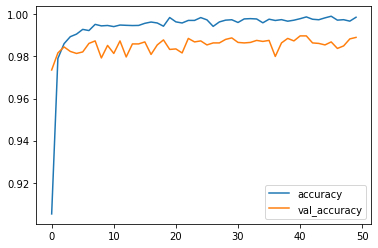

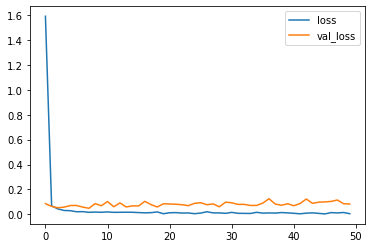

In [8]:
#check model convergence
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_frame.loc[:, ['loss', 'val_loss']].plot();


**our model clearly overfits the data we'll adress that problem with dropout neurons later**

**Let's see where our model makes mistakes using a confution matrix**

In [9]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis = -1)
y_test = np.argmax(y_test,axis = -1)
pd.DataFrame(confusion_matrix(y_test,y_pred),columns = [i for i in range(10)],index = [i for i in range(10)])

,0,1,2,3,4,5,6,7,8,9
0,424,0,0,0,0,0,2,0,0,0
1,0,433,0,0,1,0,0,1,2,1
2,0,2,416,2,0,0,0,2,1,1
3,0,0,1,402,0,1,0,0,2,1
4,0,0,0,0,373,1,1,0,4,5
5,0,0,0,3,0,397,0,0,0,0
6,0,0,0,0,1,1,401,0,0,0
7,0,1,0,0,1,0,0,427,0,2
8,0,0,0,0,0,1,1,0,428,1
9,0,0,0,0,1,0,0,1,1,453


we have many misclassification but reasnoble one's, it's easy to get confused between 4 and 9, 0 and 6, 2 and 7

# **Now we will create a more complex model using data augmentation**

In [10]:
aug_model = keras.Sequential([
    layers.InputLayer(input_shape=[28, 28, 1]),
    #CNN layer 1
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding='same'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    #CNN layer 2
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding='same'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    #CNN layer 3
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu",padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(units=1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.8),
    layers.Dense(units=512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=10, activation="softmax")
])

X_train,X_test,y_train,y_test = train_test_split(train_data.drop("label",axis = 1),y,train_size = 0.9,random_state = 100)

X_train = X_train.to_numpy().reshape(X_train.shape[0],28,28,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],28,28,1)

width_shift_val = 0.1
height_shift_val = 0.1
shear_range_val=10
zoom_range_val= 0.1
random_rotation_val = 10
datagen = ImageDataGenerator(rotation_range = random_rotation_val,width_shift_range = width_shift_val,height_shift_range = height_shift_val,zoom_range=zoom_range_val,)
datagen.fit(X_train)

aug_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

chk_point = ModelCheckpoint('./best_model.hsf5',
               monitor = 'val_accuracy',
               mode = 'max',
               save_best_model = True)

agu_history = aug_model.fit(
    datagen.flow(X_train,y_train,batch_size = 64),
    validation_data = (X_test,y_test),
    batch_size = 64,
    epochs=100,
    verbose=1,
    callbacks = [ReduceLROnPlateau(monitor="val_loss", factor = 0.6, patience = 5,verbose = 1),chk_point]
)

Epoch 1/100
591/591 [==============================] - 19s 30ms/step - loss: 1.0658 - accuracy: 0.6821 - val_loss: 0.0854 - val_accuracy: 0.9731


2021-10-19 18:42:24.725962: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
591/591 [==============================] - 18s 30ms/step - loss: 0.1707 - accuracy: 0.9479 - val_loss: 0.0515 - val_accuracy: 0.9845
Epoch 3/100
591/591 [==============================] - 18s 30ms/step - loss: 0.1264 - accuracy: 0.9619 - val_loss: 0.0562 - val_accuracy: 0.9836
Epoch 4/100
591/591 [==============================] - 18s 30ms/step - loss: 0.0985 - accuracy: 0.9693 - val_loss: 0.0492 - val_accuracy: 0.9812
Epoch 5/100
591/591 [==============================] - 18s 31ms/step - loss: 0.0838 - accuracy: 0.9740 - val_loss: 0.0254 - val_accuracy: 0.9921
Epoch 6/100
591/591 [==============================] - 18s 31ms/step - loss: 0.0783 - accuracy: 0.9758 - val_loss: 0.0371 - val_accuracy: 0.9883
Epoch 7/100
591/591 [==============================] - 18s 31ms/step - loss: 0.0781 - accuracy: 0.9775 - val_loss: 0.0264 - val_accuracy: 0.9914
Epoch 8/100
591/591 [==============================] - 19s 32ms/step - loss: 0.0714 - accuracy: 0.9782 - val_loss: 0.0268 - val_ac

**Let's see how our new model does**

,0,1,2,3,4,5,6,7,8,9
0,424,0,0,0,0,0,2,0,0,0
1,0,435,0,0,0,0,0,2,1,0
2,0,0,422,0,0,0,0,2,0,0
3,0,0,1,405,0,0,0,0,1,0
4,0,0,0,0,383,0,0,0,0,1
5,0,0,0,0,0,400,0,0,0,0
6,0,0,0,0,1,1,401,0,0,0
7,0,0,0,0,0,0,0,431,0,0
8,0,0,0,0,0,0,0,0,430,1
9,0,0,0,0,1,0,0,0,2,453


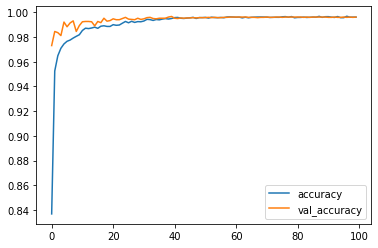

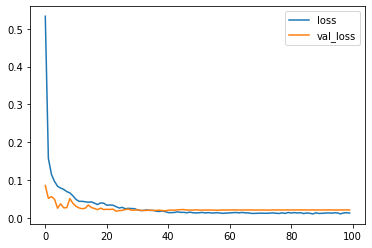

In [11]:
aug_history_frame = pd.DataFrame(agu_history.history)
aug_history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
aug_history_frame.loc[:, ['loss', 'val_loss']].plot();

y_pred = aug_model.predict(X_test)
y_pred = np.argmax(y_pred,axis = -1)
y_test = np.argmax(y_test,axis = -1)
pd.DataFrame(confusion_matrix(y_test,y_pred),columns = [i for i in range(10)],index = [i for i in range(10)])

In [12]:
# check for number of mistakes
X_train,X_test,y_train,y_test = train_test_split(train_data.drop("label",axis = 1),y,train_size = 0.9,random_state = 100)
y_test = np.argmax(y_test,axis = -1)
miss_clf = y_pred!=y_test
missed_count = sum(miss_clf)
print(sum(miss_clf))

16


**Let's take a closer look at where our model didn't do so well**

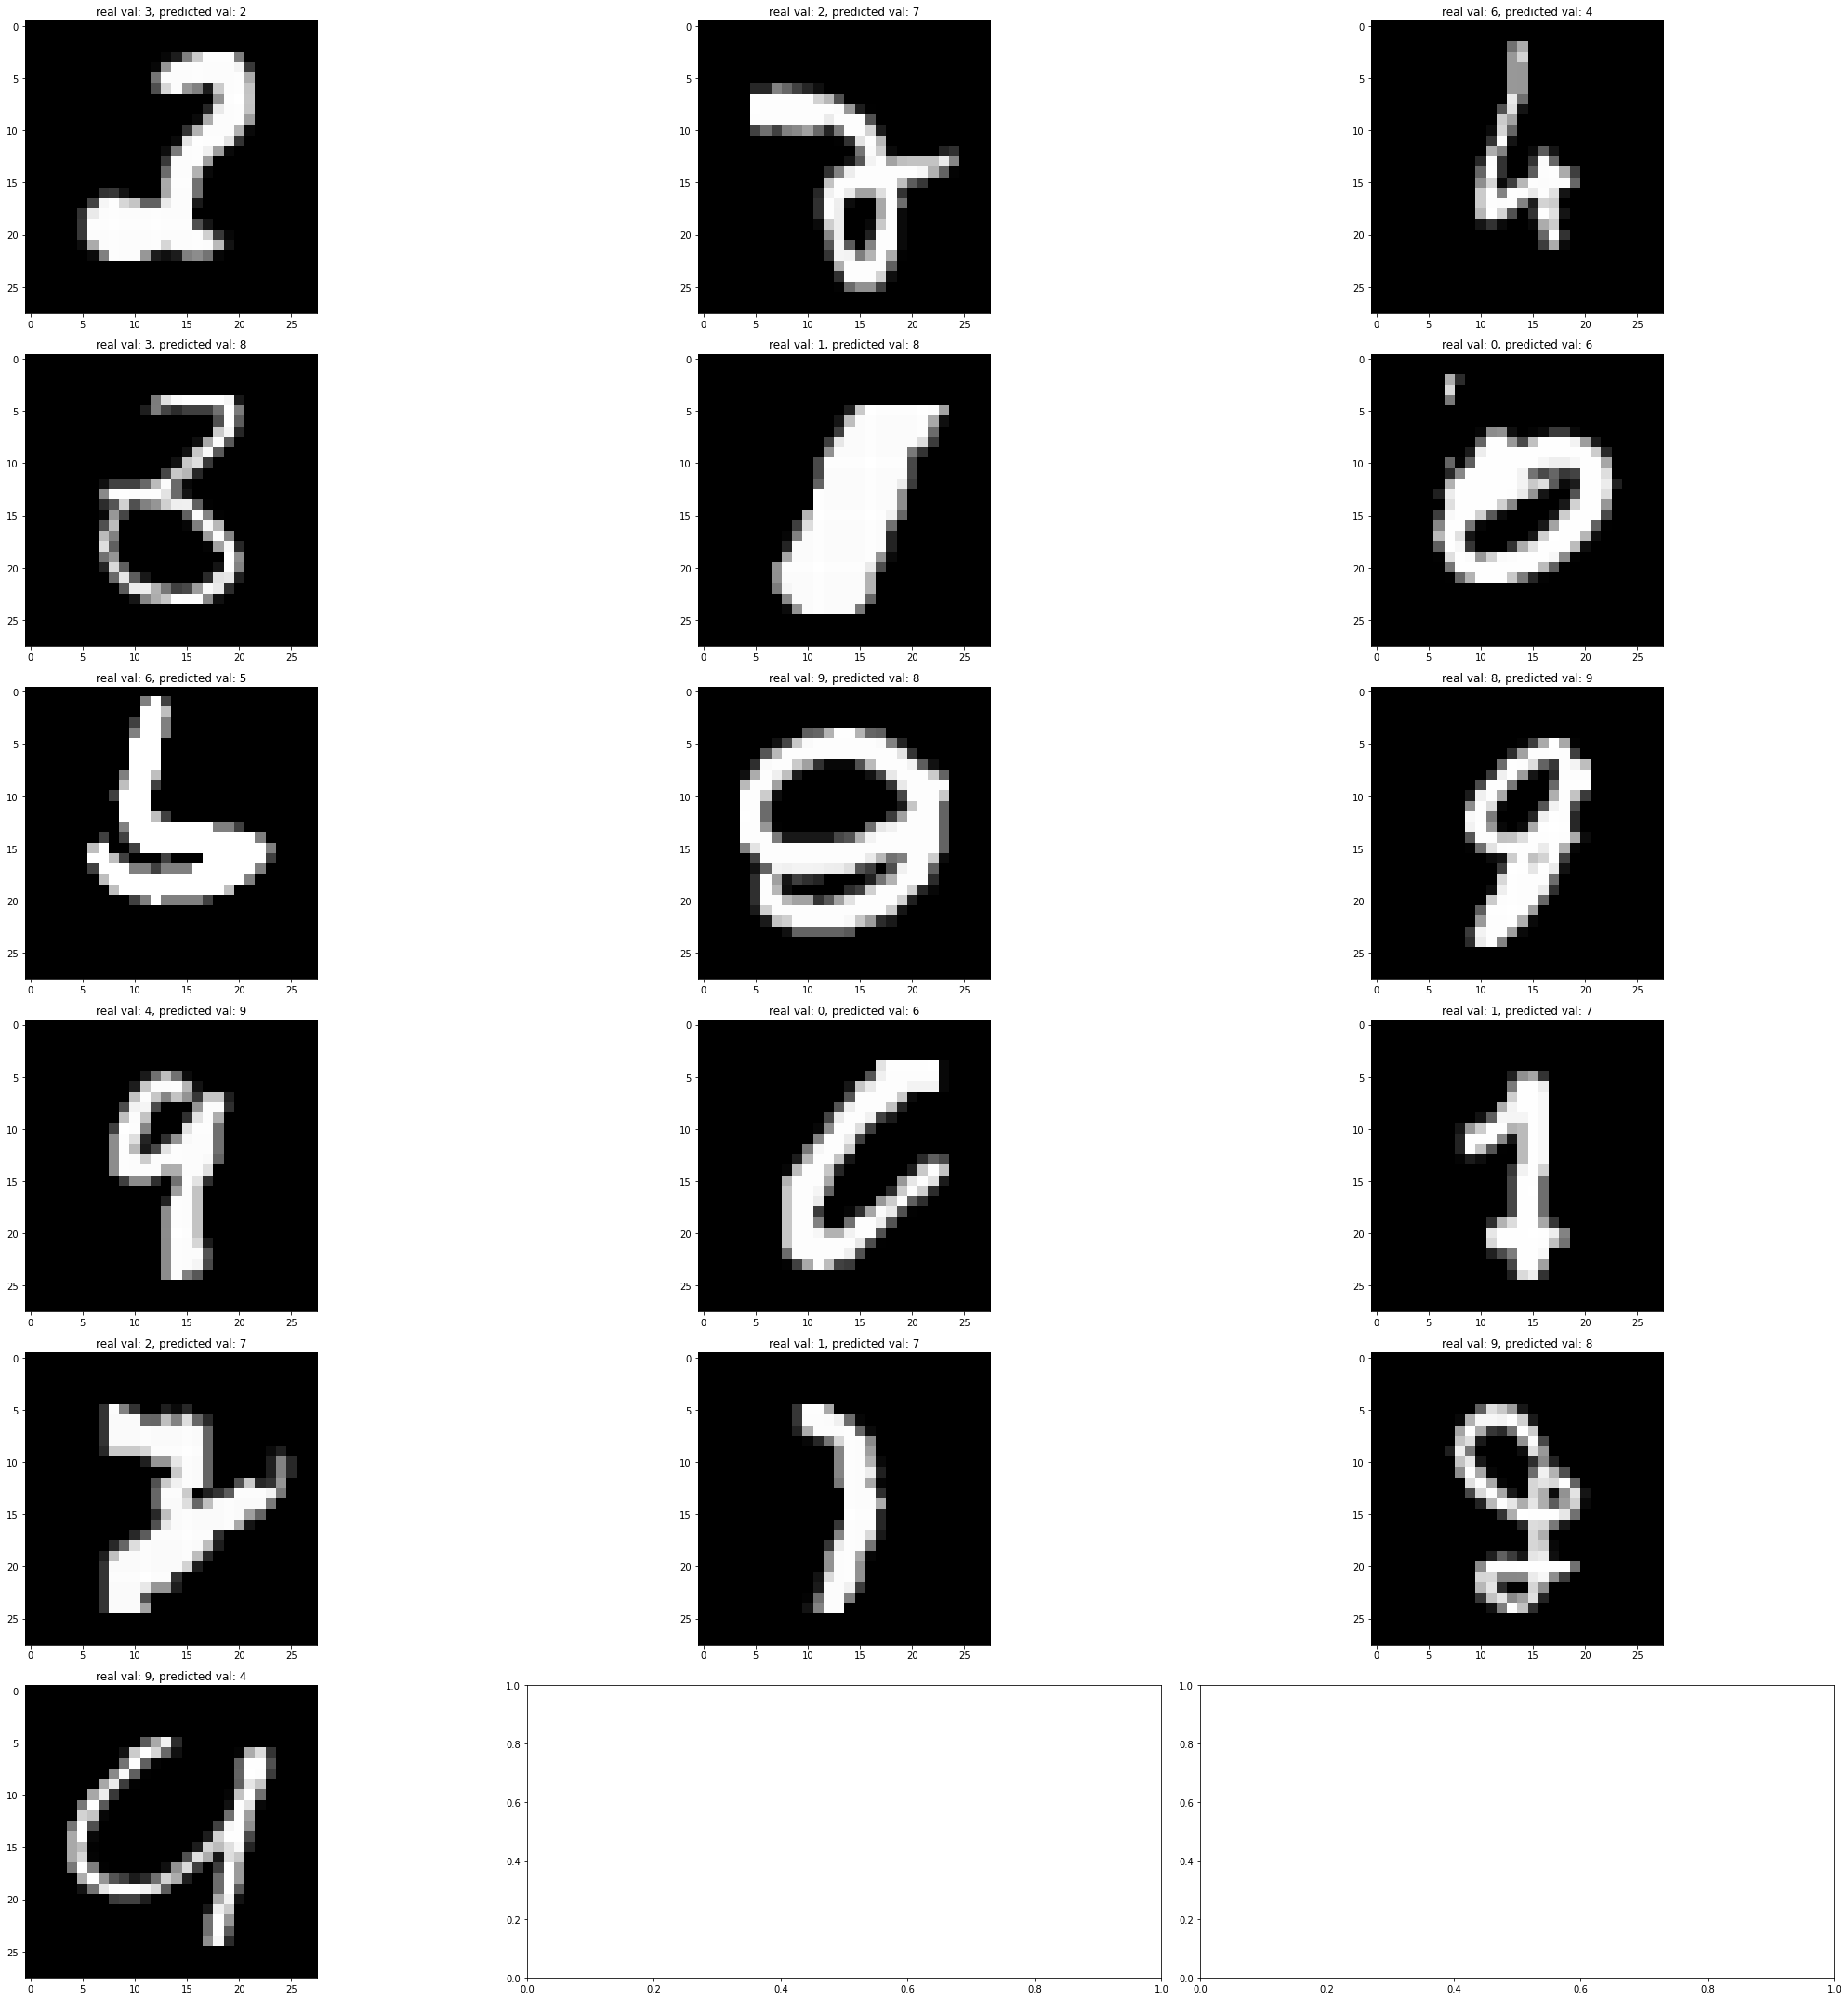

In [13]:
nrow = ceil(missed_count/3)
ncols = 3
fig, axs = plt.subplots(nrow,ncols,figsize = (30,30))
axs = axs.flatten()

ind = 0
for row,i in enumerate(miss_clf):
    if (i and ind < 30):
        x = np.array(X_test.iloc[row]).reshape(28,28,1)
        axs[ind].imshow(x, cmap='gray')
        axs[ind].set_title(f"real val: {y_test[row]}, predicted val: {y_pred[row]}")
        ind +=1
plt.tight_layout()
plt.show()

**looks like most of the misclassified images are reasonable, for most of them even a human would not classify the right number, the 9 that was wrongly classified as 8 really looks like an 8 and vice verca, also the 4's and 9's are confusing**

In [14]:
sub_label_vec = tf.keras.models.load_model('./best_model.hsf5').predict(test_data.to_numpy().reshape(test_data.shape[0],28,28,1))
sub_labels = np.argmax(sub_label_vec,axis = -1)
sub = pd.DataFrame({"ImageId":range(1,28001),"Label":sub_labels})
sub.to_csv("submmision.csv",index =False)
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# **Thanks for viewing, feel free to leave a comment and upvote :)**